<a href="https://colab.research.google.com/github/zzwony/Start_0920/blob/main/12_14_%EC%8B%9C%EA%B3%84%EC%97%B4_%EA%B8%B0%EC%98%A8%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-14 05:26:52--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.175.32, 52.217.73.198, 52.217.164.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.175.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.38MB/s    in 2.4s    

2022-12-14 05:26:55 (5.38 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
ls

drive/                      jena_climate_2009_2016.csv.zip  sample_data/
jena_climate_2009_2016.csv  __MACOSX/


In [6]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:  ## f로 열어서
  data = f.read()  ## data에 넣기

lines = data.split('\n') ## ('\n')는 줄바꿈
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [8]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

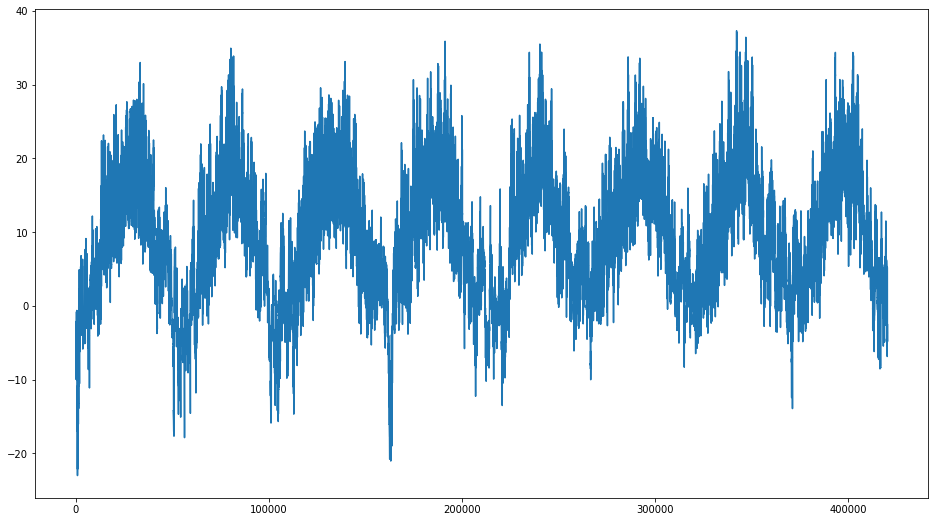

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 9))
plt.plot(range(len(temperature)), temperature)
plt.show()

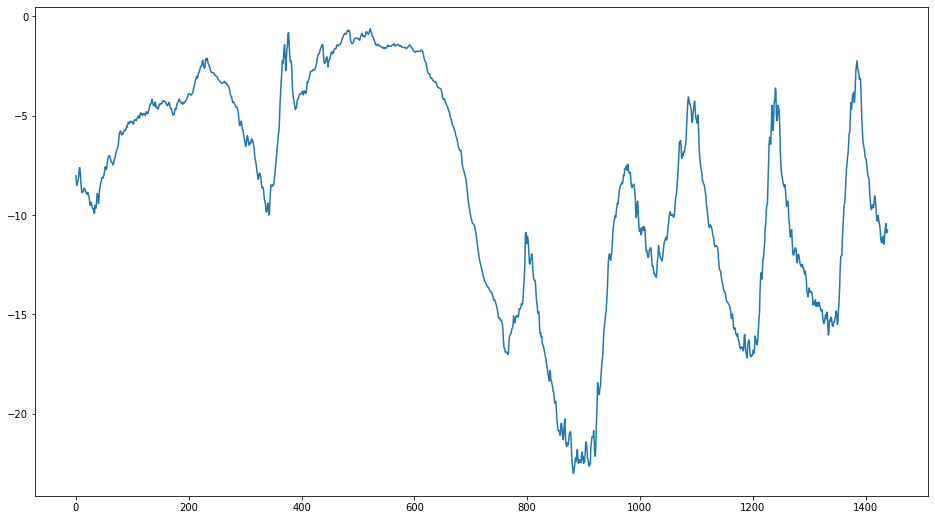

In [10]:
# 처음 10일간의 기온을 그래프로 그려보기
plt.figure(figsize=(16, 9))
plt.plot(range(1440), temperature[:1440])
plt.show()

In [11]:
# 전체 길이
len(raw_data)

420451

In [12]:
# 데이터셋을 만들건데 이번에는 train_data(50%), valdation_data(25%), test_data(나머지)로 만들것이다.
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))  #raw_data의 50%
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [13]:
# 데이터 정규화(test 쓰면 안된다.)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std  ## 나눠서 대입 ## 오차를 표준편차로 나눈것이다.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [16]:
from tensorflow import keras
sampling_rate = 6  ## 1시간이 10분씩 하면 6번이다. (즉, 10분 단위이다.)
sequence_length = 120  ## timestep이다.
delay = sampling_rate * (sequence_length + 24 - 1) ## 하루가 24시간, 시퀀스 랭스에 다음일(24) 해주고 인덱스 0이니까 하나 빼줌 거기에 6을 곱함
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array( ## 이 함수를 이용해서 구해줄 것이다.
    raw_data[:-delay],  ## -delay는 맨 끝에 있는걸 넣어줬다.
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples  ## 끝까지니까 end_index는 필요없다.
)

In [17]:
# 배치 크기 확인
for samples, targets in train_dataset:
  print(samples.shape, targets.shape)
  break

(256, 120, 14) (256,)


- 여기서 14는 칼럼의 갯수이다.
- 120은 시간 정보를 나타낸다.
- 256은 배치 사이즈이다.

In [18]:
raw_data.shape

(420451, 14)

In [21]:
from tensorflow.python import train
# 모델 구성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  ## 뒤에 있는거니까 -1이다.
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f'테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 [==============================] - 44s 51ms/step - loss: 12.2479 - mae: 2.7196 - val_loss: 11.0946 - val_mae: 2.6223
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 9.0638 - mae: 2.3681 - val_loss: 10.5046 - val_mae: 2.5627
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 8.2916 - mae: 2.2637 - val_loss: 10.1769 - val_mae: 2.5215
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 7.8468 - mae: 2.2022 - val_loss: 11.0837 - val_mae: 2.6303
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 7.5175 - mae: 2.1539 - val_loss: 10.2710 - val_mae: 2.5347
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 7.2422 - mae: 2.1159 - val_loss: 11.1762 - val_mae: 2.6475
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 7.0276 - mae: 2.0823 - val_loss: 11.2611 - val_mae: 2.6423
Epoch 8/10
819/819 [==============================] - 

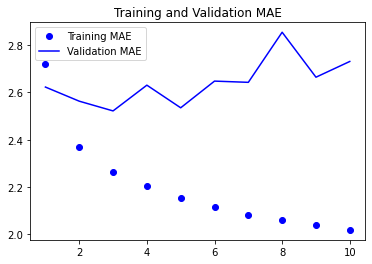

In [22]:
# 시각화
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'bo', label='Training MAE')
plt.plot(epochs, val_loss, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
# 상식 수준의 기준점
# 검증 MAE 2.44
# 테스트 MAE 2.62

## MAE는 작을수록 좋다.

#### [ 과제 ] 1D 합성곱 모델 시도

In [23]:
# 1.데이터 로드
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:  ## f로 열어서
  data = f.read()  ## data에 넣기

lines = data.split('\n') ## ('\n')는 줄바꿈
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [29]:
# 2.데이터 준비
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [30]:
# 데이터셋을 만들건데 이번에는 train_data(50%), valdation_data(25%), test_data(나머지)로 만들것이다.
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))  ##raw_data의 50%
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [31]:
# 3.데이터 정규화(test 쓰면 안된다.)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std  ## 나눠서 대입 ## 오차를 표준편차로 나눈것이다.

In [32]:
from tensorflow import keras
sampling_rate = 6  ## 1시간이 10분씩 하면 6번이다. (즉, 10분 단위이다.)
sequence_length = 120  ## timestep이다.
delay = sampling_rate * (sequence_length + 24 - 1) ## 하루가 24시간, 시퀀스 랭스에 다음일(24) 해주고 인덱스 0이니까 하나 빼줌 거기에 6을 곱함
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array( ## 이 함수를 이용해서 구해줄 것이다.
    raw_data[:-delay],  ## -delay는 맨 끝에 있는걸 넣어줬다.
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples  ## 끝까지니까 end_index는 필요없다.
)

In [44]:
# 4.Conv1D를 사용하여 모델 구성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  ## 뒤에 있는거니까 -1이다.
x = layers.Conv1D(32, 7, activation='relu')(inputs)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(32, 7, activation='relu')(inputs)
x = layers.MaxPooling1D(5)(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 114, 32)           3168      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 22, 32)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable p

In [54]:
# 5.모델 학습
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 45s 54ms/step - loss: 9.4986 - mae: 2.3970 - val_loss: 9.9944 - val_mae: 2.4537
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 8.6715 - mae: 2.2838 - val_loss: 10.0991 - val_mae: 2.4645
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 8.0820 - mae: 2.2015 - val_loss: 10.8018 - val_mae: 2.5716
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 7.6122 - mae: 2.1380 - val_loss: 10.7263 - val_mae: 2.5655
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 7.1959 - mae: 2.0765 - val_loss: 10.8962 - val_mae: 2.5660
Epoch 6/10
819/819 [==============================] - 45s 54ms/step - loss: 6.8319 - mae: 2.0262 - val_loss: 10.9538 - val_mae: 2.5785
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 6.6082 - mae: 1.9915 - val_loss: 11.6125 - val_mae: 2.6523
Epoch 8/10
819/819 [==============================] - 46

#### [ 과제 ] LSTM 기반 모델 시도

In [55]:
# 1.데이터 로드
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:  ## f로 열어서
  data = f.read()  ## data에 넣기

lines = data.split('\n') ## ('\n')는 줄바꿈
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [56]:
# 2.데이터 준비
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [57]:
# 데이터셋을 만들건데 이번에는 train_data(50%), valdation_data(25%), test_data(나머지)로 만들것이다.
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))  ##raw_data의 50%
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [58]:
# 3.데이터 정규화(test 쓰면 안된다.)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std  ## 나눠서 대입 ## 오차를 표준편차로 나눈것이다.

In [59]:
from tensorflow import keras
sampling_rate = 6  ## 1시간이 10분씩 하면 6번이다. (즉, 10분 단위이다.)
sequence_length = 120  ## timestep이다.
delay = sampling_rate * (sequence_length + 24 - 1) ## 하루가 24시간, 시퀀스 랭스에 다음일(24) 해주고 인덱스 0이니까 하나 빼줌 거기에 6을 곱함
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array( ## 이 함수를 이용해서 구해줄 것이다.
    raw_data[:-delay],  ## -delay는 맨 끝에 있는걸 넣어줬다.
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples  ## 끝까지니까 end_index는 필요없다.
)

In [60]:
# 4. LSTM 기반 모델 구성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  ## 뒤에 있는거니까 -1이다.
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm.keras',
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 5.모델 학습
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 46s 56ms/step - loss: 8.9845 - mae: 2.3397 - val_loss: 10.0228 - val_mae: 2.4581
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 7.9246 - mae: 2.2066 - val_loss: 10.0544 - val_mae: 2.4468
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 7.3186 - mae: 2.1216 - val_loss: 10.0939 - val_mae: 2.4568
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 6.9065 - mae: 2.0578 - val_loss: 10.5983 - val_mae: 2.5180
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 6.5355 - mae: 1.9993 - val_loss: 11.3635 - val_mae: 2.6097
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 6.2054 - mae: 1.9463 - val_loss: 11.0598 - val_mae: 2.5605
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 5.9267 - mae: 1.9004 - val_loss: 11.4628 - val_mae: 2.5984
Epoch 8/10
819/819 [==============================] - 4

#### [ 도전 과제 ] RNN 기반 모델 시도(스태킹)

In [63]:
# 1.데이터 로드
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:  ## f로 열어서
  data = f.read()  ## data에 넣기

lines = data.split('\n') ## ('\n')는 줄바꿈
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [64]:
# 2.데이터 준비
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [65]:
# 데이터셋을 만들건데 이번에는 train_data(50%), valdation_data(25%), test_data(나머지)로 만들것이다.
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))  ##raw_data의 50%
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [66]:
# 3.데이터 정규화(test 쓰면 안된다.)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std  ## 나눠서 대입 ## 오차를 표준편차로 나눈것이다.

In [67]:
from tensorflow import keras
sampling_rate = 6  ## 1시간이 10분씩 하면 6번이다. (즉, 10분 단위이다.)
sequence_length = 120  ## timestep이다.
delay = sampling_rate * (sequence_length + 24 - 1) ## 하루가 24시간, 시퀀스 랭스에 다음일(24) 해주고 인덱스 0이니까 하나 빼줌 거기에 6을 곱함
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array( ## 이 함수를 이용해서 구해줄 것이다.
    raw_data[:-delay],  ## -delay는 맨 끝에 있는걸 넣어줬다.
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples  ## 끝까지니까 end_index는 필요없다.
)

In [68]:
# 4. RNN 구조 모델 구성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  ## 뒤에 있는거니까 -1이다.
x = layers.Flatten()(inputs)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [69]:
# 5.모델 학습
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 43s 52ms/step - loss: 138.4060 - mae: 9.7125 - val_loss: 145.0873 - val_mae: 9.9801
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 137.8188 - mae: 9.6682 - val_loss: 144.6461 - val_mae: 9.9637
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 137.5639 - mae: 9.6461 - val_loss: 144.3686 - val_mae: 9.9244
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 137.3435 - mae: 9.6260 - val_loss: 144.3896 - val_mae: 9.9035
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 137.1899 - mae: 9.6116 - val_loss: 144.0119 - val_mae: 9.8923
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 137.1062 - mae: 9.6041 - val_loss: 143.9378 - val_mae: 9.8883
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 137.0650 - mae: 9.5999 - val_loss: 143.9191 - val_mae: 9.8852
Epoch 8/10
819/819 [==============

#### [ 도전 과제 ] 드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가

In [70]:
# 1.데이터 로드
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:  ## f로 열어서
  data = f.read()  ## data에 넣기

lines = data.split('\n') ## ('\n')는 줄바꿈
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [71]:
# 2.데이터 준비
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines),len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [72]:
# 데이터셋을 만들건데 이번에는 train_data(50%), valdation_data(25%), test_data(나머지)로 만들것이다.
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))  ##raw_data의 50%
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [73]:
# 3.데이터 정규화(test 쓰면 안된다.)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std  ## 나눠서 대입 ## 오차를 표준편차로 나눈것이다.

In [74]:
from tensorflow import keras
sampling_rate = 6  ## 1시간이 10분씩 하면 6번이다. (즉, 10분 단위이다.)
sequence_length = 120  ## timestep이다.
delay = sampling_rate * (sequence_length + 24 - 1) ## 하루가 24시간, 시퀀스 랭스에 다음일(24) 해주고 인덱스 0이니까 하나 빼줌 거기에 6을 곱함
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array( ## 이 함수를 이용해서 구해줄 것이다.
    raw_data[:-delay],  ## -delay는 맨 끝에 있는걸 넣어줬다.
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples  ## 끝까지니까 end_index는 필요없다.
)

In [77]:
# 4. 드롭아웃 규제를 적용한 LSTM 기반 모델 구성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))  ## 뒤에 있는거니까 -1이다.
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                6016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [78]:
# 5.모델 학습
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
734/819 [=========================>....] - ETA: 32s - loss: 31.3456 - mae: 4.1075

KeyboardInterrupt: ignored

#### [ 도전 과제 ] 드롭아웃 규제와 스태킹을 적용하여 GRU 모델을 훈련하고 평가

In [ ]:
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(input)